# **Tanzanian Water Wells: Predictive Maintenance for Clean Water Access**

## Executive Summary

This project addresses a critical challenge in Tanzania: **predicting the operational status of water wells** to optimize maintenance efforts and ensure reliable access to clean water for communities across the country. By leveraging machine learning classification techniques, we aim to help stakeholders prioritize resources and prevent water access disruptions.

**Key Findings:**
- Built and evaluated multiple classification models to predict well functionality
- Identified critical features that determine well failure
- Provided actionable recommendations for maintenance prioritization

# 1. Business Understanding

## 1.1 The Stakeholder

Our primary stakeholders are:
- **Tanzanian Ministry of Water**: Government agency responsible for water infrastructure
- **International NGOs**: Organizations funding and maintaining water wells
- **Local Communities**: End users dependent on functional water sources

## 1.2 The Business Problem

Tanzania faces a significant challenge with water well functionality. Many wells fall into disrepair, leaving communities without access to clean water. The problem:

- **Reactive maintenance is inefficient**: Wells are only serviced after complete failure
- **Resource constraints**: Limited funding and personnel require strategic allocation
- **Impact on communities**: Non-functional wells force communities to use unsafe water sources

## 1.3 The Business Goal

Develop a predictive model that can classify water wells into three categories:
1. **Functional**: Well is operational and needs no immediate attention
2. **Functional needs repair**: Well works but requires maintenance soon
3. **Non-functional**: Well is broken and needs immediate intervention

## 1.4 Why This Matters

Accurate predictions enable stakeholders to:
- **Prevent failures**: Address wells needing repair before they break completely
- **Optimize resources**: Focus maintenance crews on high-risk areas
- **Improve public health**: Ensure consistent access to clean water
- **Save costs**: Preventive maintenance is cheaper than emergency repairs
- **Data-driven decisions**: Move from reactive to proactive water management

# 2. Data Understanding

## 2.1 Dataset Overview

We have three data files:
- **Training set values**: Features for 59,400 wells used to train models
- **Training set labels**: The operational status (target variable) for training wells
- **Test set values**: Features for 14,850 wells where we need to predict status

### Iporting neccessary libraries

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

### Loading the datasets and submission format

In [2]:
# datasets
train_labels = pd.read_csv("0bf8bc6e-30d0-4c50-956a-603fc693d966.csv")
test_values = pd.read_csv("702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv")
train_values = pd.read_csv("4910797b-ee55-40a7-8668-10efd5c1b960.csv")
submission_format = pd.read_csv("SubmissionFormat.csv")

# data overview
print(f"Training set: {train_values.shape[0]:,} wells, {train_values.shape[1]} features")
print(f"Test set: {test_values.shape[0]:,} wells, {test_values.shape[1]} features")
print(f"Labels: {train_labels.shape[0]:,} records")

Training set: 59,400 wells, 40 features
Test set: 14,850 wells, 40 features
Labels: 59,400 records


## 2.2 Merging Training Data

The features and labels are in separate files. They need merging using the `id` column to create a complete training dataset.

In [6]:
# Merge training values with labels
train_df = train_values.merge(train_labels, on='id', how='inner')

train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [9]:
print(f"Complete training dataset: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")
print("      ")
train_df.info()

Complete training dataset: 59,400 rows, 41 columns
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 

## 2.3 Target Variable Distribution

Examining target variable: **status_group**. Understanding its distribution is critical for model evaluation.

In [19]:
# target variable distribution
target_counts = train_df['status_group'].value_counts()

target_pcts = train_df['status_group'].value_counts(normalize=True) * 100

print("Target Variable Distribution:")
print(" "*10)
for status in target_counts.index:
    count = target_counts[status]
    pct = target_pcts[status]
    print(f"{status}: {count} ({pct:.2f}%)")

Target Variable Distribution:
          
functional: 32259 (54.31%)
non functional: 22824 (38.42%)
functional needs repair: 4317 (7.27%)


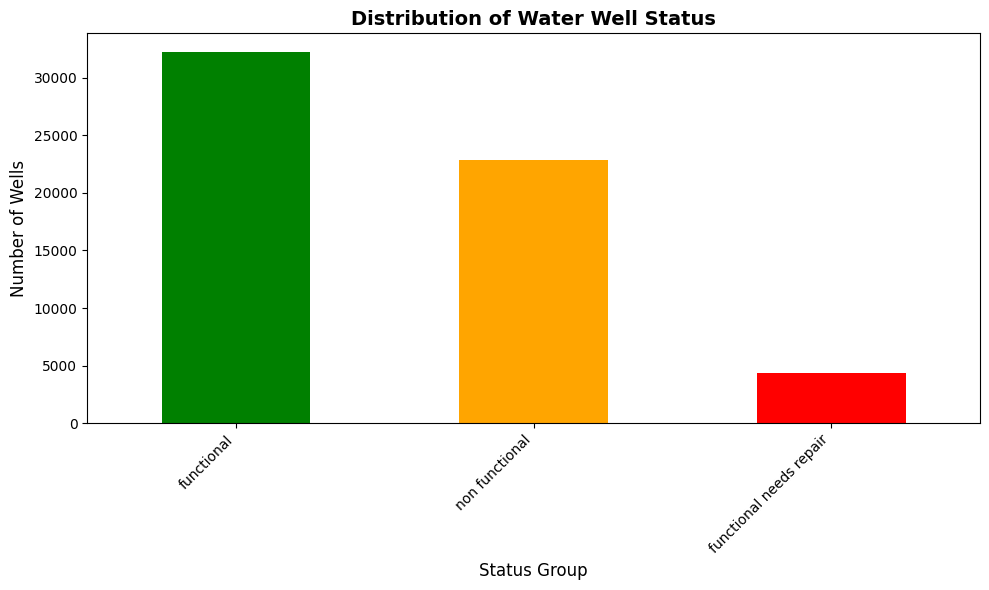

In [21]:
# Visualizing the distribution
plt.figure(figsize=(10, 6))
target_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Distribution of Water Well Status', fontsize=14, fontweight='bold')
plt.xlabel('Status Group', fontsize=12)
plt.ylabel('Number of Wells', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observations on Target Variable:

- **Class imbalance may exist**: If one class dominates, the model might be biased toward predicting that class - functional is more dominant
- **Multi-class problem**: We're predicting three outcomes, not just binary (working vs. broken)
- **Business priority**: Identifying "functional needs repair" is valuable for preventive maintenance

## 2.4 Feature Overview

Examining the types of features available for prediction.

In [26]:
# basic information about the training data
print("Dataset Information:")
print(" "*4)
train_df.info()

Dataset Information:
    
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400

The dataset contains both numeric and categorical features

In [28]:
# Separate numeric and categorical features
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()

# Remove id and target from feature lists
numeric_features = [f for f in numeric_features if f != 'id']
categorical_features = [f for f in categorical_features if f != 'status_group']


In [31]:
print(f"Total features: {len(numeric_features) + len(categorical_features)}")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features: {len(categorical_features)}")

Total features: 39
  - Numeric features: 9
  - Categorical features: 30


## 2.5 Missing Values Analysis

In [40]:
# Calculating the missing values
missing_counts = train_df.isnull().sum()
missing_counts

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

### Missing Data Observations:

- **High missing percentages** (>40%): should drop these features as imputation may introduce too much bias
- **Moderate missing** (10-40%): Can impute with appropriate strategies
- **Low missing** (<10%): Can impute or drop rows depending on feature importance

## 2.6 Summary Statistics

In [41]:
# Summary statistics for numeric features
train_df[numeric_features].describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000
